In [53]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [42]:
# see https://docs.pymc.io/notebooks/api_quickstart.html
with pm.Model() as m1:
    x = pm.Normal("x", mu=0, sigma=1)
print(x.logp({"x" : 1}))

-1.4189385332046727


In [44]:
print(m1.observed_RVs)
print(m1.free_RVs)

[]
[x ~ Normal]


In [45]:
# deterministic, stochastic
with pm.Model() as model:
    exp = pm.Exponential("exp", 1.0)
    poi = pm.Poisson("poi", exp)
    x = poi + 1
    # deterministic makes pymc keep track of intermediate results
    z = pm.Deterministic("z", poi + exp)
    
# model doesn't recognize this
y = poi + 1

In [33]:
print(type(x))
print(type(y))
print(type(z))
print(exp.tag.test_value)
print(poi.tag.test_value)
print(x.tag.test_value)

# getting samples from prior
print(exp.random(size=5))
print(poi.random(size=5))

# model.logp
#print(exp.logp({"exp": 5.}))

<class 'theano.tensor.var.TensorVariable'>
<class 'theano.tensor.var.TensorVariable'>
<class 'pymc3.model.DeterministicWrapper'>
0.6931471824645996
0
1
[0.19302285 1.23004596 0.901194   0.98116621 0.41995803]
[0 0 0 1 1]


0.4181608805025199
[1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 2 0 0 0 1 1 0 0 0 0 0 0 1 0 3 1 1 0
 0 1 0 0 0 0 0 0 1 1 2 0 0 0 0 0 2 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0]


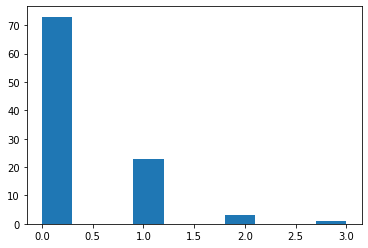

[0 0 0 0 0 0 2 0 0 0 3 2 0 0 0 0 0 0 0 0 3 4 0 1 0 2 0 0 0 2 0 2 4 1 0 0 4
 1 7 5 1 2 3 1 0 3 2 1 1 1 1 0 0 0 1 2 0 2 0 1 0 0 7 0 3 0 2 0 0 5 0 0 0 0
 0 5 3 0 2 4 0 0 0 0 0 0 0 1 0 0 1 0 0 0 2 0 1 0 0 0]


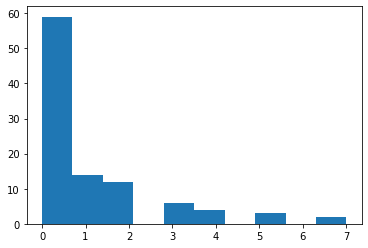

In [66]:
# artificial datasets from the prior
mu = stats.expon.rvs(scale=1.0)
print(mu)
d = stats.poisson.rvs(mu=mu, size=100)
print(d)
plt.hist(d)
plt.show()

# or 

d2 = poi.random(size=100)
print(d2)
plt.hist(d2)
plt.show()

In [164]:
# Bayesian A/B testing

# Assume we are trying to determine if some system A is better or B. We can observe a Binomial random variable indicating success
# from the system (think page visits, or binary success on some input). 


# 0.4, 0.7 are the "true" parameters, so B is better according to Nature. Note the p's are drawn independently (assume systems are not related)
# Note we have different sample sizes
p1 = 0.6
p2 = 0.8
n1 = 100
n2 = 3
a_trials = stats.bernoulli.rvs(p1, size=n1)
b_trials = stats.bernoulli.rvs(p2, size=n2)

print(a_trials.mean())
print(b_trials.mean())

# Just comparing the means will be high variance since the difference of the sample size
a_better = []
for i in range(1000):
    a_better.append(stats.bernoulli.rvs(p1, size=100).mean() > stats.bernoulli.rvs(p2, size=80))
    
print(np.array(a_better).mean())  # almost 30% chance of A being better

0.49
1.0
0.198325


In [147]:
# Use Bayesian model for a more robust way of comparing two models (by thinking about the posterior of the unknown parameter p)
with pm.Model() as m:
    p1 = pm.Uniform("p1", 0., 1.)
    p2 = pm.Uniform("p2", 0., 1.)
    ba = pm.Bernoulli("ba", p=p1, observed=a_trials)
    bb = pm.Bernoulli("bb", p=p2, observed=b_trials)
    
    delta = pm.Deterministic("delta", p2 - p1)

    trace = pm.sample(20000)

/Users/andrew.chang/miniconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 20 seconds.


In [165]:
# Binomial you need to specify n and then observed as a single number (of successful trials)
with pm.Model() as m2:
    p1 = pm.Uniform("p1", 0., 1.)
    p2 = pm.Uniform("p2", 0., 1.)
    ba = pm.Binomial("ba", p=p1, n=n1, observed=a_trials.sum())
    bb = pm.Binomial("bb", p=p2, n=n2, observed=b_trials.sum())
    
    delta = pm.Deterministic("delta", p2 - p1)

    trace = pm.sample(20000)

/Users/andrew.chang/miniconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 20 seconds.


In [110]:
#print(trace["p1"])

[0.00434981 0.00492946 0.00453345 ... 0.00456176 0.00425208 0.00464425]


<AxesSubplot:title={'center':'x'}>

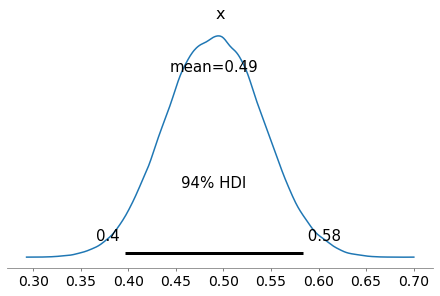

In [166]:
pm.plots.plot_posterior(trace["p1"][1000:])

(array([   44.,   294.,   771.,  1759.,  3493.,  5950.,  9047., 13274.,
        18784., 25584.]),
 array([0.06179548, 0.15561525, 0.24943501, 0.34325477, 0.43707453,
        0.53089429, 0.62471405, 0.71853381, 0.81235358, 0.90617334,
        0.9999931 ]),
 <BarContainer object of 10 artists>)

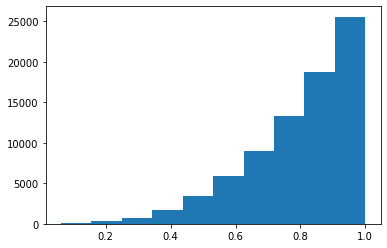

In [172]:
#pm.plots.plot_posterior(trace["p2"][1000:])
plt.hist(trace["p2"][1000:])

[0.41380921 0.1621564  0.242216   ... 0.44978656 0.08172918 0.38397455]


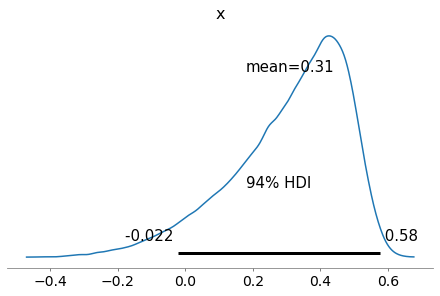

In [168]:
# Comparing the means is one way, but doesn't capture uncertainty. What if these are both really wide distributions?
# Better to compare the delta distribution
pm.plots.plot_posterior(trace["delta"][1000:])
print(trace["delta"][1000:])

In [169]:
prob_a_better = np.mean(trace["delta"][1000:] < 0)
prob_b_better = np.mean(trace["delta"][1000:] > 0)
print(prob_a_better)
print(prob_b_better)

0.06210126582278481
0.9378987341772151


In [170]:
# CAVEAT: With very small n2, using this scheme we can get high probability that B is better, even though we only saw 3 samples

In [178]:
# simulate datasets from posterior
# Binomial you need to specify n and then observed as a single number (of successful trials)
p1 = 0.8
p2 = 0.3
n1 = 1000
n2 = 2500

with pm.Model() as m2:
    p1 = pm.Uniform("p1", 0., 1.)
    p2 = pm.Uniform("p2", 0., 1.)
    ba = pm.Binomial("ba", p=p1, n=n1, observed=a_trials.sum())
    bb = pm.Binomial("bb", p=p2, n=n2, observed=b_trials.sum())
    ba_sim = pm.Binomial("ba_sim", p=p1, n=n1)
    bb_sim = pm.Binomial("bb_sim", p=p2, n=n2)

    
    delta = pm.Deterministic("delta", p2 - p1)

    trace = pm.sample(20000)
    burned_trace = trace[1000:]

/Users/andrew.chang/miniconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p2, p1]
>CompoundStep
>>Metropolis: [bb_sim]
>>Metropolis: [ba_sim]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 33 seconds.
The acceptance probability does not match the target. It is 0.978822017824704, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.967233036002202, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.974265141022603, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9605014555282158, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


(76000,)


(array([3.2200e+02, 4.2520e+03, 1.7866e+04, 2.4580e+04, 1.9354e+04,
        7.5970e+03, 1.7150e+03, 2.7800e+02, 3.3000e+01, 3.0000e+00]),
 array([ 18. ,  26.7,  35.4,  44.1,  52.8,  61.5,  70.2,  78.9,  87.6,
         96.3, 105. ]),
 <BarContainer object of 10 artists>)

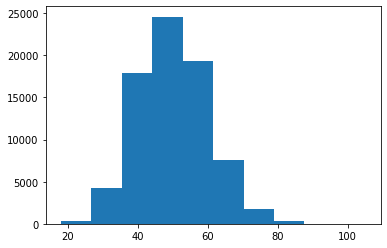

In [181]:
print(burned_trace["ba_sim"].shape)
plt.hist(burned_trace["ba_sim"])

(76000,)


(array([2.6100e+04, 2.2203e+04, 1.4355e+04, 9.5210e+03, 2.3260e+03,
        8.6800e+02, 4.9400e+02, 8.8000e+01, 3.3000e+01, 1.2000e+01]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <BarContainer object of 10 artists>)

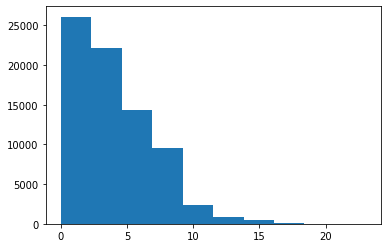

In [182]:
print(burned_trace["bb_sim"].shape)
plt.hist(burned_trace["bb_sim"])

In [ ]:
# separation plots